# XPCS Pipeline for SAXS
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Clean Data: shutter open/bad frames
* Get Q-Map
* Get 1D curve
* Define Q-ROI (qr, qz)
* Check beam damage
* One-time Correlation
* Fitting
* Two-time Correlation
The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Setup

Import packages for I/O, visualization, and analysis.

In [28]:
from chxanalys.chx_libs import (np, roi, time, datetime, os, get_events, 
                                getpass, db, get_images,LogNorm, plt,tqdm, utils, Model,
                               multi_tau_lags)

from chxanalys.chx_generic_functions import (get_detector, get_fields, get_sid_filenames,  
     load_data, load_mask,get_fields, reverse_updown, ring_edges,get_avg_img,check_shutter_open,
    apply_mask, show_img,check_ROI_intensity,run_time, plot1D, get_each_frame_intensity,                                             
    create_hot_pixel_mask,show_ROI_on_image,create_time_slice,save_lists, 

                        save_arrays, psave_obj,pload_obj, get_non_uniform_edges )
 



from chxanalys.XPCS_SAXS import (get_circular_average,save_lists,get_ring_mask, get_each_ring_mean_intensity,
                                 plot_qIq_with_ROI,save_saxs_g2,plot_saxs_g2,fit_saxs_g2,cal_g2,
                                create_hot_pixel_mask,get_circular_average,get_t_iq,save_saxs_g2,
                                plot_saxs_g2,fit_saxs_g2,fit_q2_rate,plot_saxs_two_g2,fit_q_rate,
                                circular_average,plot_saxs_g4, get_t_iqc,multi_uids_saxs_xpcs_analysis,
                                 save_g2)


from chxanalys.Two_Time_Correlation_Function import (show_C12, get_one_time_from_two_time,
                                                get_four_time_from_two_time,rotate_g12q_to_rectangle)
from chxanalys.chx_compress import (combine_binary_files,
                           segment_compress_eigerdata,     create_compress_header,            
                            para_segment_compress_eigerdata,para_compress_eigerdata)

from chxanalys.chx_compress_analysis import ( compress_eigerdata, read_compressed_eigerdata,
                                             Multifile,get_avg_imgc, get_each_frame_intensityc,
                get_each_ring_mean_intensityc, mean_intensityc,cal_waterfallc,plot_waterfallc,  
)

from chxanalys.SAXS import fit_form_factor
from chxanalys.chx_correlationc import ( cal_g2c,Get_Pixel_Arrayc,auto_two_Arrayc,get_pixelist_interp_iq,)
from chxanalys.chx_correlationp import (cal_g2p, auto_two_Arrayp)

from chxanalys.Create_Report import (create_pdf_report, 
                                create_multi_pdf_reports_for_uids,create_one_pdf_reports_for_uids)


from chxanalys.XPCS_GiSAXS import (get_qedge,get_qmap_label,get_qr_tick_label, get_reflected_angles,
    convert_gisaxs_pixel_to_q, show_qzr_map, get_1d_qr, get_qzrmap, show_qzr_roi,get_each_box_mean_intensity,
    save_gisaxs_g2,plot_gisaxs_g2, fit_gisaxs_g2,plot_gisaxs_two_g2,plot_qr_1d_with_ROI,fit_qr_qz_rate,
                                  multi_uids_gisaxs_xpcs_analysis,plot_gisaxs_g4,
                                  get_t_qrc, plot_t_qrc)
import sys
import pandas as pds
%matplotlib notebook

## Give the file full path here

In [6]:
file_path = '/XF11ID/analysis/2016_3/yuzhang/Results/42a28b54-9263-42a6-8e60-50ee7f7d3e51/'
file_name = 'uid=42a28b54-9263-42a6-8e60-50ee7f7d3e51--g2.csv'
fp = file_path + file_name

## Get data

In [9]:
data_g2 = pds.read_csv( fp )

## explore data

In [29]:
data_g2

,Unnamed: 0,tau,0.00675,0.0113611111111,0.0159722222222,0.0205833333333,0.0251944444444,0.0298055555556,0.0344166666667,0.0390277777778,0.0436388888889,0.04825
0,0,0.00000,2.006211,1.821745,2.010712,2.600910,4.326079,10.454350,23.476355,27.937253,29.245318,39.224457
1,1,0.00134,1.947240,1.608787,1.522167,1.531190,1.526196,1.539309,1.595485,1.509440,1.474772,1.459757
2,2,0.00268,1.948562,1.605800,1.518070,1.525796,1.517310,1.521284,1.562660,1.487457,1.456649,1.440210
3,3,0.00402,1.939031,1.596864,1.509497,1.515906,1.503673,1.498313,1.531220,1.458531,1.438995,1.418641
4,4,0.00536,1.921615,1.583935,1.497999,1.503910,1.488603,1.477231,1.501853,1.440439,1.423849,1.406903
5,5,0.00670,1.920089,1.575984,1.490223,1.495151,1.478163,1.460684,1.481288,1.422968,1.413964,1.396546
6,6,0.00804,1.898634,1.561297,1.478636,1.484007,1.465165,1.444938,1.464161,1.409245,1.402826,1.386710
7,7,0.00938,1.894578,1.552342,1.471000,1.476123,1.455985,1.434314,1.453858,1.401389,1.394490,1.379169
8,8,0.01072,1.882617,1.541608,1.462682,1.468066,1.447872,1.425586,1.444623,1.398155,1.390910,1.379839
9,9,0.01340,1.862144,1.522420,1.447952,1.454447,1.434981,1.413303,1.435327,1.390985,1.387330,1.377515


In [43]:
data_g2.columns

Index(['Unnamed: 0', 'tau', '0.00675', '0.0113611111111', '0.0159722222222',
       '0.0205833333333', '0.0251944444444', '0.0298055555556',
       '0.0344166666667', '0.0390277777778', '0.0436388888889', '0.04825'],
      dtype='object')

## Plot data

<IPython.core.display.Javascript object>


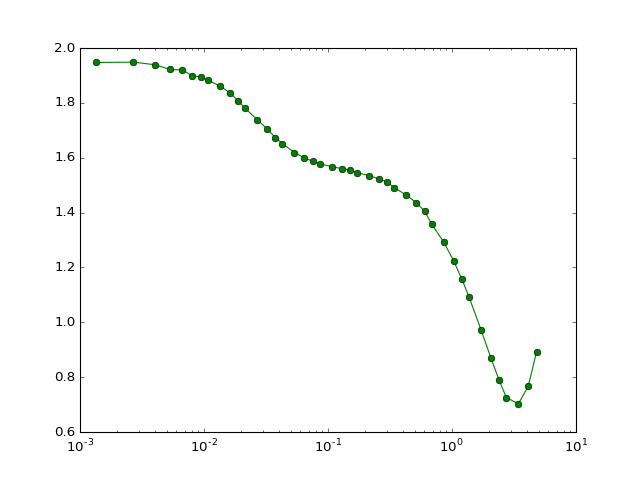

In [41]:
fig,ax=plt.subplots()
ax.semilogx(  np.array( data_g2['tau'][1:] ),  np.array( data_g2['0.00675'][1:]),  'go-'  )
#ax.plot(  np.array( data_g2['tau'][1:] ), np.array( data_g2['0.00675'][1:]), 'go', ls='--'  )